In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

from scipy import stats
import graphviz
from IPython.display import display

from sklearn.preprocessing import StandardScaler, normalize

import statsmodels.api as sm

In [2]:
df = pd.read_csv('data.csv', sep = ';')

<b> Переменные, характеризующие кредитную историю клиента </b>
- closed_cred_sum - сумма, которую клиент выплатил по ранее взятым и закрытым
кредитам
- closed_creds - количество закрытых кредитов
- active_cred_sum_overdue - суммарная задолженность по активным кредитам
- active_cred_sum - сумма всех активных кредитов
- active_cred_day_overdue - суммарная просрочка в днях по всем активным кредитам
- active_cred_max_overdue - максимальная сумма просроченной задолженности по активным кредитам 
<br>

<b> Переменные характеризующие клиента </b>
- age - возраст
- gender - пол
- region - регион
- month_income - ежемесячный доход
<br>

<b>Переменные, характеризующие кредит, по которому нужно сделать прогноз </b>
- first_loan - сумма, которую клиент хочет получить в кредит (из заявки)
- first_days_quant - срок, на которую клиент хочет взять кредит
- loan_cost_all - одобренная клиенту сумма кредита
- order_date - дата подачи заявки на получение кредита
- cost_all - сумма всех выплат по одобренному кредиту
- order_id - id заявки
- client_id - id клиента


## Анализ данных

In [3]:
df

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
0,143822.00,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,2017-07-23,0.0,728319,320464,1
1,0.00,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,2017-07-23,0.0,728321,320466,1
2,51356.00,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,2017-07-23,0.0,728323,320467,1
3,0.00,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,2017-07-23,0.0,728447,320533,1
4,12298.00,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,2017-07-23,0.0,728421,298598,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,0.00,0,74662.61,79662.61,2593,42204.55,27,1,0,4000.0,4000,20,0.0,2017-08-13,0.0,759472,96091,1
49997,21653.49,2,0.00,0.00,0,0.00,28,0,75,2000.0,2000,10,20000.0,2017-08-13,0.0,759475,338240,1
49998,0.00,0,0.00,1000.00,0,941.00,22,0,0,10000.0,10000,20,35000.0,2017-08-13,0.0,759485,338246,1
49999,0.00,0,0.00,1000.00,0,941.00,22,0,0,10000.0,10000,20,35000.0,2017-08-13,0.0,759485,338246,1


Оценим общую информацию о данных

In [4]:
df.describe()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,order_id,client_id,expert
count,5.000100e+04,50001.000000,5.000100e+04,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,50001.000000,49982.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000
mean,1.865780e+05,7.974001,5.217919e+04,1.964205e+05,722.563769,3.776984e+04,35.018900,0.462691,28.825083,7751.682606,6703.681926,23.954561,24943.402642,1233.828788,734747.279874,290563.956781,0.749265
std,5.057408e+05,13.933307,2.537311e+05,4.365213e+05,1371.656677,1.703992e+05,11.235206,0.498611,29.726162,5310.782009,4610.529844,36.670176,20652.768218,4556.672041,26254.078989,74592.964584,0.433441
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,18.000000,0.000000,0.000000,2000.000000,0.000000,0.000000,0.000000,0.000000,695828.000000,109.000000,0.000000
25%,5.502000e+03,1.000000,0.000000e+00,1.467400e+04,0.000000,4.870800e+02,27.000000,0.000000,0.000000,5000.000000,3000.000000,10.000000,0.000000,0.000000,715042.000000,294858.000000,0.000000
50%,4.287400e+04,4.000000,5.000000e+03,5.703022e+04,64.000000,6.765660e+03,32.000000,0.000000,25.000000,7000.000000,7000.000000,20.000000,25000.000000,0.000000,734707.000000,316156.000000,1.000000
75%,1.740713e+05,9.000000,3.157990e+04,1.972360e+05,923.000000,2.449949e+04,41.000000,1.000000,52.000000,10000.000000,10000.000000,20.000000,35000.000000,0.000000,749477.000000,330172.000000,1.000000
max,4.457421e+07,563.000000,3.303100e+07,2.273166e+07,21927.000000,2.170166e+07,99.000000,1.000000,99.000000,100000.000000,100000.000000,336.000000,550000.000000,238770.420000,840692.000000,393528.000000,1.000000


Исследуем данные на мультиколлинеарность

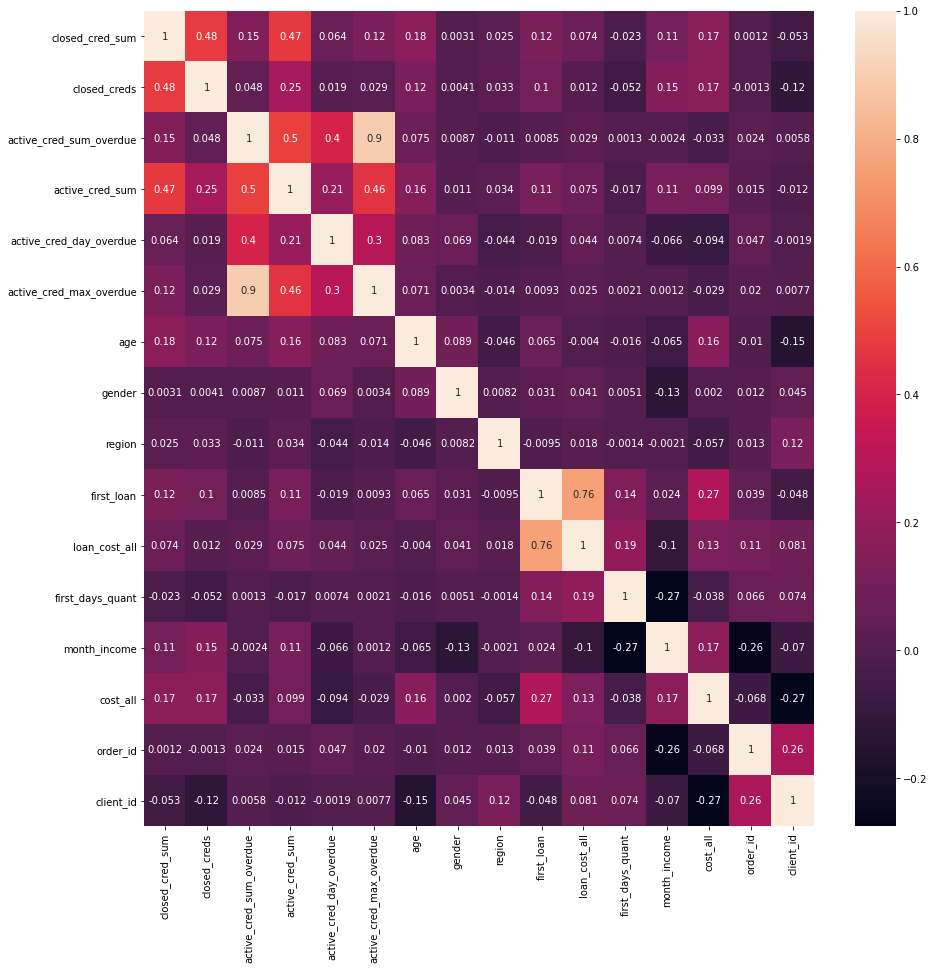

In [5]:
plt.figure(figsize = (15, 15))
hm = sns.heatmap(df.loc[:, (df.columns != 'order_date') & (df.columns != 'expert')].corr(),
                cbar = True,
                annot=True)

Оценим распределение данных в зависимости от оценки эксперта (исключим крайние случаи для большей наглядности графиков, так как в данных содержится много нулевых значений и несколько анаомальных)

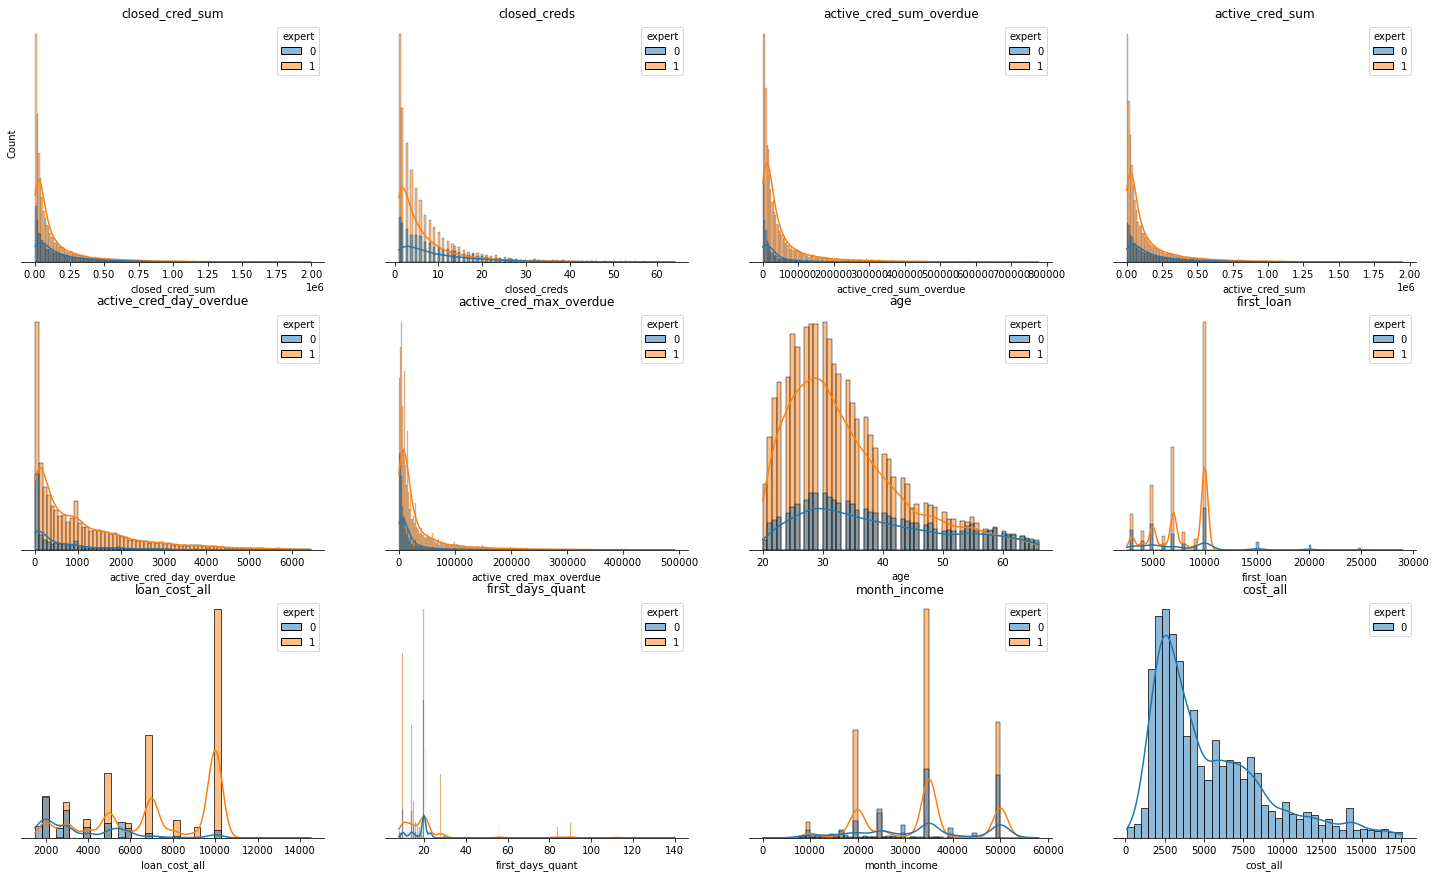

In [6]:
columns = df.columns[:-3].values
columns = columns[(columns != 'gender') & (columns != 'region') & (columns != 'order_date')]
n_rows = 3 
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 15))
sns.despine(left=True)
for idx, col_name in enumerate(columns):
    low = df[col_name].quantile(0.01)
    high  = df[col_name].quantile(0.99)
    ax = axes[idx // 4,idx % 4]
    sns.histplot(df[(df[col_name] < high) & (df[col_name] > low)], x=col_name, hue="expert", kde=True, fill=True, ax=ax)
    plt.setp(axes, yticks=[])
    ax.title.set_text(col_name)

В большинстве случаев данные распределены одинаково для разных оценок экспертов, за исключением, пожалуй, "loan_cost_all" исходя из распределений этого параметра, можно увидеть, что эксперты чаще положительно оценивают небольшие суммы кредитов.
<br>

Так же можно выделить, признак "cost_all" который не имеет отрицательных оценок экспертов для данного интервала, изучим его подробнее.

C:\Users\duran\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='cost_all', ylabel='Count'>

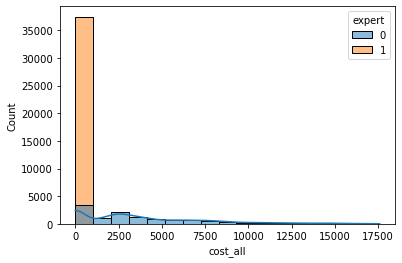

In [7]:
col_name = 'cost_all'
high  = df[col_name].quantile(0.99)
sns.histplot(df[(df[col_name] < high)], x=col_name, hue="expert", kde = True, fill=True)

In [8]:
df.loc[df['cost_all'] != 0 ]['expert'].value_counts()

0    9244
Name: expert, dtype: int64

Отсюда можно увидеть, что отличные от нуля значения данного признака, содержат только положительные оценки экспертов. Исходя так же из описания данного признака, можно предположить, что он содержит информацию, которая ещё не доступна на момент принятия решения, поэтому данный признак следует исключить из дальнейшего рассмотрения. 



In [9]:
df = df.drop(['cost_all'], axis = 1)

Оценим Так же признак 'loan_cost_all'

In [10]:
df.loc[df['loan_cost_all'] != 0 ]['expert'].value_counts()

1    37463
0    12537
Name: expert, dtype: int64

Скорее всего данный признак доступен заранее для оценки экспертов, так как явяется предположительной суммой, которую готов предоставить банк в кредит.

<b> Анализ важности призаков </b>

Проведём анализ важности признаков на основе показателей IV и WoE, которые оценивают важность признаков и их вклад в определённое решение эксперта соответственно

<img src = https://www.machinelearningmastery.ru/img/0-709508-33003.png>

In [11]:
df_bins = pd.DataFrame()
columns = df.columns[:-3].values
columns = columns[(columns != 'gender') & (columns != 'region') & (columns != 'order_date')]
for col_name in columns:
    df_bins[col_name + ' bins'] = pd.qcut(df[col_name], q = 4, duplicates = 'drop')
df_bins['region'] = df['region']
df_bins['gender'] = df['gender']
df_bins['expert'] = df['expert']

In [12]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [13]:
ivs = {}
for col_name in df_bins.columns[:-1]:
    print('WoE and IV for column: {}'.format(col_name))
    df_scores, iv = calculate_woe_iv(df_bins, col_name, 'expert')
    ivs.update({col_name : iv})
    display(df_scores)
    print( '\033[1m' + 'IV score: {:.2f}' .format(iv) + '\033[0m')
    print('\n')

WoE and IV for column: closed_cred_sum bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
1,"(-0.001, 5502.0]",12501,1685,10816,0.134402,0.288704,-0.764565,0.117974
2,"(5502.0, 42874.0]",12501,2692,9809,0.214724,0.261825,-0.198320,0.009341
0,"(42874.0, 174071.28]",12499,3512,8987,0.280131,0.239884,0.155103,0.006242
3,"(174071.28, 44574209.38]",12500,4648,7852,0.370743,0.209588,0.570365,0.091917


IV score: 0.23


WoE and IV for column: closed_creds bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
1,"(-0.001, 1.0]",15897,2144,13753,0.171014,0.367099,-0.763888,0.149787
2,"(1.0, 4.0]",12204,2614,9590,0.208503,0.255979,-0.205143,0.009739
3,"(4.0, 9.0]",9687,2833,6854,0.225971,0.182949,0.211200,0.009086
0,"(9.0, 563.0]",12213,4946,7267,0.394512,0.193973,0.709932,0.142369


IV score: 0.31


WoE and IV for column: active_cred_sum_overdue bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
1,"(31579.9, 33030999.24]",12500,1526,10974,0.121720,0.292921,-0.878183,0.150346
2,"(5000.0, 31579.9]",12191,1794,10397,0.143096,0.277520,-0.662373,0.089038
0,"(-0.001, 5000.0]",25310,9217,16093,0.735184,0.429559,0.537361,0.164231


IV score: 0.40


WoE and IV for column: active_cred_sum bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
1,"(14674.0, 57030.22]",12500,2411,10089,0.192311,0.269299,-0.336708,0.025922
2,"(-0.001, 14674.0]",12501,2796,9705,0.223020,0.259049,-0.149755,0.005396
0,"(57030.22, 197236.0]",12500,3285,9215,0.262024,0.245969,0.063230,0.001015
3,"(197236.0, 22731655.24]",12500,4045,8455,0.322645,0.225683,0.357420,0.034656


IV score: 0.07


WoE and IV for column: active_cred_day_overdue bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
1,"(923.0, 21927.0]",12500,1361,11139,0.108559,0.297325,-1.007537,0.190189
2,"(64.0, 923.0]",12469,1795,10674,0.143176,0.284914,-0.688110,0.097531
0,"(-0.001, 64.0]",25032,9381,15651,0.748265,0.417761,0.582848,0.192634


IV score: 0.48


WoE and IV for column: active_cred_max_overdue bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
1,"(24499.49, 21701655.24]",12499,1908,10591,0.152190,0.282698,-0.619253,0.080818
2,"(6765.66, 24499.49]",12501,2333,10168,0.186089,0.271407,-0.377394,0.032199
0,"(487.08, 6765.66]",12500,3589,8911,0.286273,0.237855,0.185283,0.008971
3,"(-0.001, 487.08]",12501,4707,7794,0.375449,0.208040,0.590393,0.098837


IV score: 0.22


WoE and IV for column: age bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
2,"(17.999, 27.0]",14162,2403,11759,0.191673,0.313875,-0.493205,0.060271
0,"(27.0, 32.0]",11321,2301,9020,0.183537,0.240764,-0.271404,0.015532
3,"(32.0, 41.0]",12821,3091,9730,0.246550,0.259716,-0.052023,0.000685
1,"(41.0, 99.0]",11697,4742,6955,0.378240,0.185645,0.711694,0.137069


IV score: 0.21


WoE and IV for column: first_loan bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
3,"(5000.0, 7000.0]",9696,1575,8121,0.125688,0.216843,-0.545370,0.049713
0,"(7000.0, 10000.0]",21255,3514,17741,0.280425,0.473712,-0.524296,0.101340
1,"(1999.999, 5000.0]",16923,5768,11155,0.460298,0.297856,0.435265,0.070706
2,"(10000.0, 100000.0]",2108,1674,434,0.133589,0.011588,2.444755,0.298261


IV score: 0.52


WoE and IV for column: loan_cost_all bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
0,"(7000.0, 10000.0]",18511,767,17744,0.061179,0.473628,-2.046620,0.844126
1,"(3000.0, 7000.0]",17874,3929,13945,0.313392,0.372224,-0.172040,0.010121
2,"(10000.0, 100000.0]",717,292,425,0.023291,0.011344,0.719361,0.008594
3,"(-0.001, 3000.0]",12899,7549,5350,0.602138,0.142804,1.439015,0.660988


IV score: 1.52


WoE and IV for column: first_days_quant bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
0,"(20.0, 336.0]",10817,1485,9332,0.118449,0.249092,-0.743338,0.097112
2,"(-0.001, 10.0]",12606,2831,9775,0.225812,0.260917,-0.144502,0.005073
1,"(10.0, 20.0]",26578,8221,18357,0.655739,0.489990,0.291377,0.048295


IV score: 0.15


WoE and IV for column: month_income bins


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
0,"(-0.001, 25000.0]",25447,4497,20950,0.358698,0.559204,-0.444032,0.089031
2,"(25000.0, 35000.0]",13342,3629,9713,0.289463,0.259262,0.110188,0.003328
1,"(35000.0, 550000.0]",11212,4411,6801,0.351839,0.181534,0.661728,0.112695


IV score: 0.21


WoE and IV for column: region


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
97,85,17,1,16,0.000080,0.000427,-1.677893,0.000583
86,43,16,1,15,0.000080,0.000400,-1.613354,0.000517
88,95,44,3,41,0.000239,0.001094,-1.520264,0.001300
78,31,26,2,24,0.000160,0.000641,-1.390210,0.000669
74,56,128,11,117,0.000877,0.003123,-1.269582,0.002851
...,...,...,...,...,...,...,...,...
6,0,20061,6255,13806,0.498923,0.368514,0.302974,0.039511
19,41,807,288,519,0.022972,0.013853,0.505753,0.004612
96,72,32,12,20,0.000957,0.000534,0.583871,0.000247
98,9,7,3,4,0.000239,0.000107,0.807014,0.000107


IV score: 0.29


WoE and IV for column: gender


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
1,1,23135,5493,17642,0.438143,0.470905,-0.072112,0.002363
0,0,26866,7044,19822,0.561857,0.529095,0.060080,0.001968


IV score: 0.00




Построим график важности признаков на основе данных коэффициентов

In [14]:
def plot_bar(data):
    plt.bar(data.keys(), data.values() )
    plt.xticks(rotation = 90)
    plt.show()

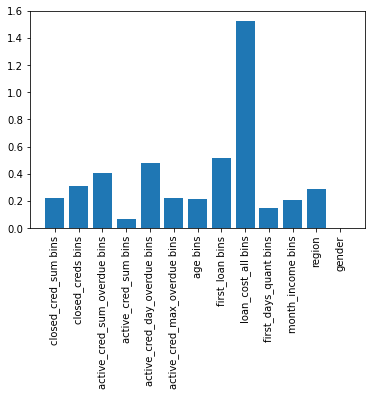

In [15]:
plot_bar(ivs)

Из него видно, что наиболее значимым параметром, является признак 'loan_cast_all', а такие признаки как, например 'gender' или 'active_cred_sum' не играют важной роли в силу схожего распределения для различных оценок эксперта

# Фильтрация данных

Исследование на пропущенные значения (имеем 19 пропущенных значений для одного из признаков)

In [16]:
df.isna().sum()

closed_cred_sum             0
closed_creds                0
active_cred_sum_overdue     0
active_cred_sum             0
active_cred_day_overdue     0
active_cred_max_overdue     0
age                         0
gender                      0
region                      0
first_loan                 19
loan_cost_all               0
first_days_quant            0
month_income                0
order_date                  0
order_id                    0
client_id                   0
expert                      0
dtype: int64

Это небольшое количество, относительно оъёма данных, поэтому можем удалить соответствующие строки

In [17]:
df = df.dropna()

Исследование объясняемой переменной (имеем дело с несбаланированной выборкой)

In [18]:
target_count = df['expert'].value_counts()
print('target 0: {} \ntarget 1: {}'.format(target_count[0] / (target_count[1] + target_count[0]), target_count[1] / (target_count[1] + target_count[0]))) 

target 0: 0.25071025569204913 
target 1: 0.7492897443079508


<b> Проверим статистическую значисость признаков </b>

In [19]:
X = df.loc[:, (df.columns != 'expert') & (df.columns != 'order_date')]
y = df['expert'].values  

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.194494
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                49982
Model:                          Logit   Df Residuals:                    49967
Method:                           MLE   Df Model:                           14
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                  0.6546
Time:                        23:09:34   Log-Likelihood:                -9721.2
converged:                       True   LL-Null:                       -28146.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
closed_cred_sum            -0.0780      0.019     -4.190      0.000      -0.114  

Все признаки являются статистически значимыми, за исключением признаков "active_cred_max_overdue" и "active_cred_sum_overdue"
<br>

Отсутствие статистической значимости "active_cred_sum_overdue", объясняется, скорее всего, его корреляцией с "active_cred_max_overdue", проверим это удалив один из признаков

In [20]:
df = df.drop(['active_cred_max_overdue'], axis = 1)

Действительно, все оставшиеся признаки статистически значимы

In [21]:
X = df.loc[:, (df.columns != 'expert') & (df.columns != 'order_date')]
y = df['expert'].values  

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.194506
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                49982
Model:                          Logit   Df Residuals:                    49968
Method:                           MLE   Df Model:                           13
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                  0.6546
Time:                        23:09:34   Log-Likelihood:                -9721.8
converged:                       True   LL-Null:                       -28146.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
closed_cred_sum            -0.0773      0.019     -4.177      0.000      -0.114  

# Преобразование переменных

Большая честь признаков представляет собой численные переменные, за исключением двух:
- region
- gender

<br>
Они являются категориальными неупорядоченными признаками
<br>

gender просто удалим, так как признак показал низкую значимость

<br>

region, чтобы не создавать 100 новых переменных, приведём к упорядоченному виду и будем использовать как численную переменную.
Для этого отсортируем регионы по признаку количества одобренных кредитов и сопоставим кажому региону соответствующий номер в данном рейтинге.

In [22]:
def data_preparation(df):
    df = df.drop(['order_date', 'gender'], axis = 1)
    
    # region transform
    df_scores, iv = calculate_woe_iv(df_bins, 'region', 'expert')    
    ordered_region = dict(zip(df_scores.sort_values(by = ['Distr_Good'])['Value'], np.array(range(1,100)))) 

    X = df.loc[:, df.columns != 'expert']
    y = df['expert']    
    
    
    return X, y

# Моделирование


<b>Выбор модели</b>

<br>

В качестве модели для прогнозирования данных были выбраны алгоритмы основанные на решающих деревьях, так как алгоритмы принятия решения данной группы алгоритмов схожи с базовыми методами кредитного скоринга

<br>

Пример характеристик, используемых в кредитном скоринге

<img src = https://www.researchgate.net/profile/Shafiq-Ur-Rehman-Massan/publication/332470263/figure/tbl1/AS:748703182778368@1555516157465/Example-of-different-characteristics-used-in-Credit-Scoring-Application-Bredan-Jayagopal.png>


<b> Выбор и обоснование выбора метрики</b>

При оценке работы данной модели, важно не только количество правильно соотнесённых с классом объектов, но и величина суммы кредита в случае одобрения / неодобрения эксперта так как одна неверно одобренная заявка на большую сумму может быть важнее множества неверно одобренных на более мелкие суммы. 

<br>

Поэтому я разработал метрику, которая учитывает данные показатели.

- losses -  количество денег потраченное на кредиты, которые не вернут
- income - доход от выданных кредитов, которые вернут
- potential_losses - убыток от кредитов, которые не были выданы

<b> metric = income  / (losses + potential_losses) </b>

<br>

Примечание. Доход рассчитывался как количество выданных денег умноженное на кол-во запрашиваемых дней на возврат кредита, умноженное на условную процентную ставку 0.01
<br>

Таким образом данное отношение не указывает на то, прибыльным ли будет такая политика выдачи кредитов, но только позволяет сравнивать разные модели между собой.
<br>

Но при наличии информации о кредитной политике, данная метрика так же будет указывать на возможную прибыль.

In [23]:
def losses_metric(model, y_test, X_test):
    
    preds = model.predict(X_test)
    
    X_test_explore = X_test.copy()
    X_test_explore['terget'] = y_test
    X_test_explore['preds']= preds
    
    conditions =  {'FN' : (X_test_explore['terget'] == 1) & (X_test_explore['preds'] == 0),
                   'FP' : (X_test_explore['terget'] == 0) & (X_test_explore['preds'] == 0),
                   'TN' : (X_test_explore['terget'] == 0) & (X_test_explore['preds'] == 1),
                   'TP' : (X_test_explore['terget'] == 1) & (X_test_explore['preds'] == 1)}
    
    losses = X_test_explore.loc[conditions['FN']]['loan_cost_all'].sum()
    income = X_test_explore.loc[conditions['FP']].loc[:,['loan_cost_all', 'first_days_quant']].prod(axis = 1).sum() * 0.01
    potential_losses = X_test_explore.loc[conditions['TN']].loc[:,['loan_cost_all', 'first_days_quant']].prod(axis = 1).sum() * 0.01
    
    df = pd.DataFrame([[losses, income, potential_losses]], columns = ['losses', 'income', 'potential_losses'])
    
    return income  / (losses + potential_losses), df
    

In [24]:
def evaluate_model(model, y_test, X_test):
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    
    metric, df = losses_metric(model, y_test, X_test)
    
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show() 
    
    display(df)
    print('\033[1m' + 'metric is: {}' .format(metric) + '\033[0m')
    
    return metric

Построим первую модель (без учёта имбалансности выборки)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2606
           1       0.97      0.99      0.98      7391

    accuracy                           0.97      9997
   macro avg       0.96      0.95      0.96      9997
weighted avg       0.97      0.97      0.97      9997



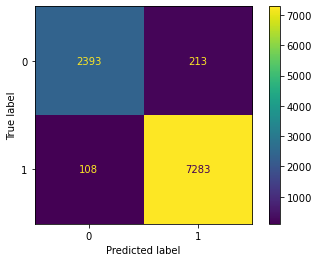

,losses,income,potential_losses
0,421500,1748956.0,175260.0


metric is: 2.9307527314163146


In [25]:
X, y = data_preparation(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
metric = evaluate_model(clf, y_test, X_test)

<b>Построим вторую модель (с учётом имбалансности выборки)

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2606
           1       0.96      0.99      0.98      7391

    accuracy                           0.96      9997
   macro avg       0.97      0.94      0.95      9997
weighted avg       0.96      0.96      0.96      9997



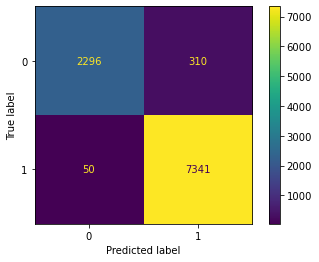

,losses,income,potential_losses
0,202500,1661436.0,262780.0


metric is: 3.5708304676753784


In [26]:
X, y = data_preparation(df)
_, vals = np.unique(y, return_counts=True)

# учтём несбалансированность классов
weights = vals[1] / vals[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

clf = xgb.XGBClassifier(scale_pos_weight = weights)
clf.fit(X_train, y_train)
metric = evaluate_model(clf, y_test, X_test)

Несмотря на то, что у первой модели такие показатели как precision, recall, f1-score не ниже(а то и выше), чем у второй модели,  значение нашей метрики выше всё же у второй модели (построенной с учётом несбалансированности классов), что говорит о необходимости учёта обозначенных метрикой показателей и недостаточности простого подсчёта количества верно определённых объектов и их отношений

<br>

Так же можно обратить внимание на соотношение FP и FN у второй модели, она имеет более низкое значение FN и более высокое FP, что является частым случаем для моделей предсказывающих одобрение/неодобрение кредита

Построим график важности признаков для второй модели

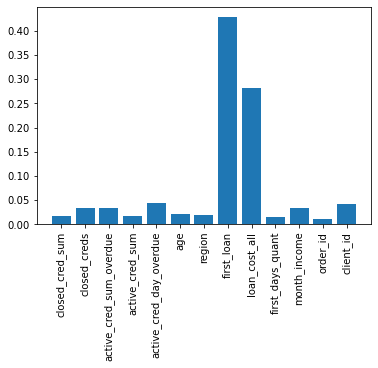

In [27]:
plot_bar(dict(zip(clf.get_booster().feature_names, clf.feature_importances_)))

Наиболее выжными признаками, ожидаемо, оказались размеры кредита указаных банком/клиентом

<b> Построим ансамбль моделей </b>

Все эксперименты не были включены в финальный ноутбук, но по их результатам было принято решение остановиться на ансамбле из двух классификаторов XGBClassifier и LGBMClassifier. Каждый из них был построен с учётом несбалансированности выборки, данные параметры выбраны исходя из анализа признаков (общее направление на большее кол-во более глубоких деревьев, для выделения неявных закономерностей с небольшим шагом обучения, так как анализ признаков не показал явных различий между распределениями признаков для разных решений экспертов)

<br>

Так же был предоставлен функционал для обучения модели с учётом весов(т.е размера кредита) для каждого экземпляра данных

In [28]:
def model_ensembling(df, use_sample_weights = False):
    X, y = data_preparation(df)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 1)
    
    if use_sample_weights:
        sample_weights = normalize(X_train['loan_cost_all'].values.reshape(-1,1), axis = 0)
    else:
        sample_weights = np.ones(X_train.shape[0])
    
    _, vals = np.unique(y, return_counts=True)
    
    weights = vals[1]/ vals[0]
    
    class_weight = {0: (vals[0] / vals[1]), 
                    1: (vals[1] / vals[0])}
    
    clf1 = LGBMClassifier(learning_rate=0.12, n_estimators = 650, class_weight = class_weight)
    clf2 = xgb.XGBClassifier(objective = 'binary:logistic', max_depth = 16, tree_method = 'gpu_hist', scale_pos_weight = weights, learning_rate = 0.1)
    
    eclf1 = VotingClassifier(estimators=[ ('lgbm', clf1), ('XGB', clf2)], voting='soft', weights = [1.5,1])
    eclf1 = eclf1.fit(X_train, y_train, sample_weight = sample_weights.squeeze())
      
    evaluate_model(eclf1, y_test, X_test)
    
    return eclf1
    

# Оценка качества модели

Ансамбль без учёта весов объектов

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2606
           1       0.97      0.99      0.98      7391

    accuracy                           0.97      9997
   macro avg       0.97      0.95      0.96      9997
weighted avg       0.97      0.97      0.97      9997



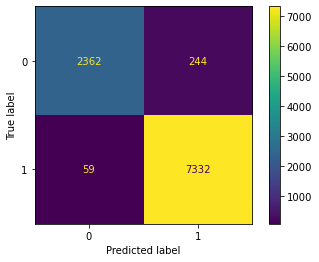

,losses,income,potential_losses
0,234500,1745121.0,179095.0


metric is: 4.219395785732419


In [29]:
ens_clf = model_ensembling(df)

Ансамбль с учётом весов объектов(не показал лучших результатов в данном случае, хотя для некоторых моделей, помогал улучшать показатель)

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2606
           1       0.96      0.99      0.98      7391

    accuracy                           0.96      9997
   macro avg       0.97      0.94      0.95      9997
weighted avg       0.96      0.96      0.96      9997



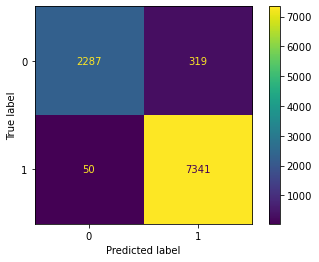

,losses,income,potential_losses
0,219500,1698136.0,226080.0


metric is: 3.8110687194218773


In [30]:
ens_clf = model_ensembling(df, use_sample_weights = True)

# Выводы

- наиболее важными оказались признаки обозначающие сумму кредита, что было заметно и на графиках распределений признаков в зависимости от оценки экспертов
- большинство признаков статистически значимы, за исключением коррелирующих признаков
- модели, построенные на основе решающих деревьев, хорошо справляются с данной задачей, кроме того они дают хорошую интерпретируемость за счёт схожести с методами кредитного скоринга
- введённая метрика, хорошо подходит для оценки данных моделей, так как учитывает факторы, не принимаемые в расчёт классическими метриками